<a href="https://colab.research.google.com/github/GGoYoungHee/Dacon_koreanNLP/blob/main/kogpt2_kornli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- https://github.com/ukairia777/tensorflow-nlp-tutorial/blob/main/22.%20Fine-tuning%20GPT-2%20with%20different%20tasks/22-5.%20kogpt2_kornli_tpu.ipynb
- 참고 자료임
- 2019년도에 나온 모델?

In [ ]:
cd /content/drive/MyDrive/Dacon_KoreanNLP

/content/drive/MyDrive/Dacon_KoreanNLP


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.0 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
     |████████████████████████████████| 895 kB 48.9 MB/s 
     |████████████████████████████████| 6.8 MB 41.8 MB/s 
     |████████████████████████████████| 596 kB 54.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import transformers
transformers.__version__

'4.16.2'

In [ ]:
import pandas as pd
import numpy as np
import urllib.request
import os
from tqdm import tqdm
import tensorflow as tf
from sklearn import preprocessing
from transformers import AutoTokenizer, TFGPT2Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# 훈련데이터 
df=pd.read_csv('open/train_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24998 entries, 0 to 24997
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       24998 non-null  int64 
 1   premise     24998 non-null  object
 2   hypothesis  24998 non-null  object
 3   label       24998 non-null  object
dtypes: int64(1), object(3)
memory usage: 781.3+ KB


In [ ]:
len(df)

24998

In [ ]:
df =df.sample(frac=1) # 랜덤하게 섞기
df

,index,premise,hypothesis,label
13079,13079,"이런 부정확한 정보는 사람들을 혼란에 빠뜨리고, 분별력을 상실하게 하여 오히려 전염...",이런 부정확한 정보가 일으키는 문제가 요즘 사회적으로 제일 심각하다.,neutral
17130,17130,공모 자격은 골목 거주 주민 5인 이상이면 신청이 가능하고 신청 단위별 1개 골목만...,골목에 사는 사람들에게 공모 신청 자격이 있다.,entailment
20198,20198,"2007년, 러시아의 블라디미르 푸틴 대통령이 대사관에 머무르던 당시에도 수류탄이 ...",대사관에 수류탄이 투척된 적은 없다.,contradiction
17291,17291,김영록 전라남도지사와 김부겸 행안부장관의 발걸음이 보성으로 향하게 한 것도 김 군수...,김부겸은 문체부 장관이다.,contradiction
11934,11934,숙소는 아주 깨끗하고 시내와도 가까워요.,시내와 가까운 곳에 숙소가 있습니다.,entailment
...,...,...,...,...
9880,9880,"그러나 학교 측은 학생들에게 해당 학과의 재정율이 낮고, 취업률 등 여러가지 상황을...",해당 학부가 통폐합되는 단 한 가지 이유는 취업률이다.,contradiction
16864,16864,숙소도 굉장히 깨끗하고 호스트도 엄청 친절해요.,인테리어가 깔끔해요.,neutral
19449,19449,"대한민국 버스업계가 2012년 11월 22일 부터 파업에 들어갈 것으로 예상되어, ...",버스업계는 요금인상이 받아들여지지 않아서 파업을 결정했다.,neutral
3936,3936,다른 곳 볼 필요도 없이 정말 최고였어요.,아 곳이 정말 최악이었어요.,contradiction


In [ ]:
x=df[['index','premise','hypothesis']]
y=df[['label']]

In [ ]:
## 훈련데이터 , 검증데이터 
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.2,shuffle=True,random_state=2022)



In [ ]:
train_data=pd.concat([x_train,y_train],axis=1)
val_data=pd.concat([x_val,y_val],axis=1)
# train_data=df.copy()

In [ ]:
train_data

,index,premise,hypothesis,label
9447,9447,"청년회 회원들이 안전을 관리하고 있어 안전하고 신나게 물놀이를 즐길 수 있고, 물놀...",청년회 회원들이 물놀이장의 안전을 관리한다.,entailment
5639,5639,2021년 6월 1일 이후 양도분부터 적용된다.,2021년 6월 1일의 양도분은 적용된다.,entailment
2669,2669,"부엌, 냉장고 등도 마음대로 사용할 수 있어요.",세탁기는 사용할 수 없어요.,neutral
13732,13732,이런게 영화라고 극장에 걸린다는 사실이 공포다.,이런 영화가 성공한 사실이 공포다.,neutral
17888,17888,백씨의 가족들과 농민 단체 등은 강신명 경찰청장을 비롯한 책임자들을 살인미수 혐의로...,백씨의 가족과 농민 단체는 강신명 경찰청장만 고발했다.,contradiction
...,...,...,...,...
61,61,"각 분야별 전문가 의견수렴을 거쳐 보고서 내 연구의 신뢰도를 견고한 동의, 중간적 ...",보고서 내 연구의 신뢰도를 3단계로 평가해 제시했다.,entailment
3868,3868,전남 목포시 출연기관인 목포수산식품지원센터에서 수산물 고부가가치화를 위해 수년간 연...,목포시는 목포수산식품지원센터에 엄청난 자금을 지원해주었다.,neutral
12610,12610,"그 외에도 학교의 안전관리를 위해 경찰과 소방관을 참여시키고, 의용소방대를 활용해 ...",학교의 안전관리를 위해 소방관을 참여시키는 방안도 들어있습니다.,entailment
6196,6196,광진구 자양동의 한 구멍가게에서 똑같은 수법으로 거스름돈을 챙기려다 주인 할머니의 ...,광진구 자양동의 한 구멍가게에서 똑같은 수법으로 거스름돈을 챙겼으나 경찰은 검거에 ...,contradiction


In [ ]:
val_data

,index,premise,hypothesis,label
11221,11221,"근처에 로컬마트, 한인마트가 있어 편리합니다.","한인마트, 로컬마트가 근처에 있습니다.",entailment
5928,5928,오늘 회의에 김사열 국가균형발전위원장님과 또 강현수 국토연구원 원장님께서 참석해 주...,국가균형발전위원장이 오늘 회의에 참석해 주셨습니다.,entailment
8125,8125,"봉사활동을 원하는 누구나 참여가능하며, 모집분야는 경로식당, 밑반찬배달이다.",봉사활동은 모두에게 열려있다.,entailment
19956,19956,그녀의 집은 말할 것도 없이 좋았습니다.,그녀는 집을 가지고 있습니다.,entailment
15086,15086,오랜 시간 열심히 조립한 완성품을 보는 만큼 뿌듯한 순간도 없다.,오랜 시간 열심히 조립한 완성품을 보는 것은 그다지 성취감을 느낄 수 없다.,contradiction
...,...,...,...,...
12937,12937,화장실 되게 깨끗하고 사용하기 편해요.,형편없는 화장실이 아니에요.,entailment
7921,7921,중국의 어느 시골길에서 한 청년이 2시간 가까이 기다려 44번 버스를 탄다.,중국의 시골길에는 44번 버스만 다닌다.,neutral
10769,10769,정책의 지속성이 그만큼 한국판 뉴딜의 성패를 좌우할수 있다는 의미다.,정책의 지속성은 한국판 뉴딜의 성패에 관해 손톱만큼도 관여할 수 없다.,contradiction
7136,7136,후원에 관한 문의는 전남사회복지공동모금회나 화순군 희망복지지원단으로 하면 된다.,전남 사회복지공동모금회와 화순군 희망복지지원단은 더이상 후원에 관한 문의를 받지 않는다.,contradiction


In [ ]:
df[df['index']==17225]

,index,premise,hypothesis,label
17225,17225,"이에 정책금융기관장들은 한국판 뉴딜의 취지에 적극 공감하고, 디지털, 그린 뉴딜 부...","이에 정책금융기관장들은 한국판 뉴딜의 의도에 적극 공감하고, 디지털, 그린 뉴딜 부...",entailment


In [ ]:
# test data
test_data=pd.read_csv('open/test_data.csv')

In [ ]:
test_data

,index,premise,hypothesis,label
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,answer
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,answer
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,answer
3,3,몇 번을 다시봐도 볼 때마다 가슴이 저민다.,다시 봤을때는 무덤덤했다.,answer
4,4,"8월 중에 입주신청을 하면 청년은 9월, 신혼부부는 10월부터 입주가 가능하다.",8월 중에 입주신청을 하면 신혼부부는 9월 부터 입주가 가능하다.,answer
...,...,...,...,...
1661,1661,"또 작업자의 숙련도와 경험 향상, 전문성을 요구하는 난이도 높은 데이터 가공을 통해...",이미지 데이터를 가공하는 것이 가장 난이도가 높다.,answer
1662,1662,결말을 보니 아무래도 이 영화는 2부가 계획된 듯 합니다.,결말을 보니 분명히 2편이 나올것이 틀림없다.,answer
1663,1663,사회적 거리 두기 상황에서 총리도 카페를 갔다가 자리가 없어서 퇴짜 맞은 일도 있을...,사회적 거리두기 상황에서는 고위관직자도 방역지침을 준수해야 한다.,answer
1664,1664,로마에서 3박4일간 이곳에서 머물렀습니다.,이곳에서 머무르며 로마의 명소들을 방문했습니다.,answer


In [ ]:
def drop_na_and_duplciates(df):
  df = df.dropna()
  df = df.drop_duplicates()
  df = df.reset_index(drop=True)
  return df

In [ ]:
# 결측값 및 중복 샘플 제거
train_data = drop_na_and_duplciates(train_data)
val_data = drop_na_and_duplciates(val_data)
test_data = drop_na_and_duplciates(test_data)

In [ ]:
df

,index,premise,hypothesis,label
13079,13079,"이런 부정확한 정보는 사람들을 혼란에 빠뜨리고, 분별력을 상실하게 하여 오히려 전염...",이런 부정확한 정보가 일으키는 문제가 요즘 사회적으로 제일 심각하다.,neutral
17130,17130,공모 자격은 골목 거주 주민 5인 이상이면 신청이 가능하고 신청 단위별 1개 골목만...,골목에 사는 사람들에게 공모 신청 자격이 있다.,entailment
20198,20198,"2007년, 러시아의 블라디미르 푸틴 대통령이 대사관에 머무르던 당시에도 수류탄이 ...",대사관에 수류탄이 투척된 적은 없다.,contradiction
17291,17291,김영록 전라남도지사와 김부겸 행안부장관의 발걸음이 보성으로 향하게 한 것도 김 군수...,김부겸은 문체부 장관이다.,contradiction
11934,11934,숙소는 아주 깨끗하고 시내와도 가까워요.,시내와 가까운 곳에 숙소가 있습니다.,entailment
...,...,...,...,...
9880,9880,"그러나 학교 측은 학생들에게 해당 학과의 재정율이 낮고, 취업률 등 여러가지 상황을...",해당 학부가 통폐합되는 단 한 가지 이유는 취업률이다.,contradiction
16864,16864,숙소도 굉장히 깨끗하고 호스트도 엄청 친절해요.,인테리어가 깔끔해요.,neutral
19449,19449,"대한민국 버스업계가 2012년 11월 22일 부터 파업에 들어갈 것으로 예상되어, ...",버스업계는 요금인상이 받아들여지지 않아서 파업을 결정했다.,neutral
3936,3936,다른 곳 볼 필요도 없이 정말 최고였어요.,아 곳이 정말 최악이었어요.,contradiction


In [ ]:
train_data

,index,premise,hypothesis,label
0,9447,"청년회 회원들이 안전을 관리하고 있어 안전하고 신나게 물놀이를 즐길 수 있고, 물놀...",청년회 회원들이 물놀이장의 안전을 관리한다.,entailment
1,5639,2021년 6월 1일 이후 양도분부터 적용된다.,2021년 6월 1일의 양도분은 적용된다.,entailment
2,2669,"부엌, 냉장고 등도 마음대로 사용할 수 있어요.",세탁기는 사용할 수 없어요.,neutral
3,13732,이런게 영화라고 극장에 걸린다는 사실이 공포다.,이런 영화가 성공한 사실이 공포다.,neutral
4,17888,백씨의 가족들과 농민 단체 등은 강신명 경찰청장을 비롯한 책임자들을 살인미수 혐의로...,백씨의 가족과 농민 단체는 강신명 경찰청장만 고발했다.,contradiction
...,...,...,...,...
19993,61,"각 분야별 전문가 의견수렴을 거쳐 보고서 내 연구의 신뢰도를 견고한 동의, 중간적 ...",보고서 내 연구의 신뢰도를 3단계로 평가해 제시했다.,entailment
19994,3868,전남 목포시 출연기관인 목포수산식품지원센터에서 수산물 고부가가치화를 위해 수년간 연...,목포시는 목포수산식품지원센터에 엄청난 자금을 지원해주었다.,neutral
19995,12610,"그 외에도 학교의 안전관리를 위해 경찰과 소방관을 참여시키고, 의용소방대를 활용해 ...",학교의 안전관리를 위해 소방관을 참여시키는 방안도 들어있습니다.,entailment
19996,6196,광진구 자양동의 한 구멍가게에서 똑같은 수법으로 거스름돈을 챙기려다 주인 할머니의 ...,광진구 자양동의 한 구멍가게에서 똑같은 수법으로 거스름돈을 챙겼으나 경찰은 검거에 ...,contradiction


In [ ]:
val_data

,index,premise,hypothesis,label
0,11221,"근처에 로컬마트, 한인마트가 있어 편리합니다.","한인마트, 로컬마트가 근처에 있습니다.",entailment
1,5928,오늘 회의에 김사열 국가균형발전위원장님과 또 강현수 국토연구원 원장님께서 참석해 주...,국가균형발전위원장이 오늘 회의에 참석해 주셨습니다.,entailment
2,8125,"봉사활동을 원하는 누구나 참여가능하며, 모집분야는 경로식당, 밑반찬배달이다.",봉사활동은 모두에게 열려있다.,entailment
3,19956,그녀의 집은 말할 것도 없이 좋았습니다.,그녀는 집을 가지고 있습니다.,entailment
4,15086,오랜 시간 열심히 조립한 완성품을 보는 만큼 뿌듯한 순간도 없다.,오랜 시간 열심히 조립한 완성품을 보는 것은 그다지 성취감을 느낄 수 없다.,contradiction
...,...,...,...,...
4995,12937,화장실 되게 깨끗하고 사용하기 편해요.,형편없는 화장실이 아니에요.,entailment
4996,7921,중국의 어느 시골길에서 한 청년이 2시간 가까이 기다려 44번 버스를 탄다.,중국의 시골길에는 44번 버스만 다닌다.,neutral
4997,10769,정책의 지속성이 그만큼 한국판 뉴딜의 성패를 좌우할수 있다는 의미다.,정책의 지속성은 한국판 뉴딜의 성패에 관해 손톱만큼도 관여할 수 없다.,contradiction
4998,7136,후원에 관한 문의는 전남사회복지공동모금회나 화순군 희망복지지원단으로 하면 된다.,전남 사회복지공동모금회와 화순군 희망복지지원단은 더이상 후원에 관한 문의를 받지 않는다.,contradiction


In [ ]:
len(val_data)+len(train_data)

24998

In [ ]:
len(df)

24998

In [ ]:
test_data

,index,premise,hypothesis,label
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,answer
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,answer
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,answer
3,3,몇 번을 다시봐도 볼 때마다 가슴이 저민다.,다시 봤을때는 무덤덤했다.,answer
4,4,"8월 중에 입주신청을 하면 청년은 9월, 신혼부부는 10월부터 입주가 가능하다.",8월 중에 입주신청을 하면 신혼부부는 9월 부터 입주가 가능하다.,answer
...,...,...,...,...
1661,1661,"또 작업자의 숙련도와 경험 향상, 전문성을 요구하는 난이도 높은 데이터 가공을 통해...",이미지 데이터를 가공하는 것이 가장 난이도가 높다.,answer
1662,1662,결말을 보니 아무래도 이 영화는 2부가 계획된 듯 합니다.,결말을 보니 분명히 2편이 나올것이 틀림없다.,answer
1663,1663,사회적 거리 두기 상황에서 총리도 카페를 갔다가 자리가 없어서 퇴짜 맞은 일도 있을...,사회적 거리두기 상황에서는 고위관직자도 방역지침을 준수해야 한다.,answer
1664,1664,로마에서 3박4일간 이곳에서 머물렀습니다.,이곳에서 머무르며 로마의 명소들을 방문했습니다.,answer


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('skt/kogpt2-base-v2', bos_token='<s>', eos_token='</s>', pad_token='<pad>')

Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.69M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
print(tokenizer.encode("보는내내 그대로 들어맞는 예측 카리스마 없는 악역"))

[11867, 7071, 7071, 10554, 9359, 7498, 7162, 15305, 9488, 10191, 7487, 9712, 9868, 8031]


In [ ]:
print(tokenizer.tokenize("보는내내 그대로 들어맞는 예측 카리스마 없는 악역"))

['▁보는', '내', '내', '▁그대로', '▁들어', '맞', '는', '▁예측', '▁카', '리스', '마', '▁없는', '▁악', '역']


In [ ]:
tokenizer.decode(tokenizer.encode("보는내내 그대로 들어맞는 예측 카리스마 없는 악역"))

'보는내내 그대로 들어맞는 예측 카리스마 없는 악역'

In [ ]:
for elem in tokenizer.encode("보는내내 그대로 들어맞는 예측 카리스마 없는 악역"):
  print(tokenizer.decode(elem))

보는
내
내
그대로
들어
맞
는
예측
카
리스
마
없는
악
역


In [ ]:
print(tokenizer.tokenize("전율을 일으키는 영화. 다시 보고싶은 영화"))

['▁전', '율을', '▁일으키는', '▁영화', '.', '▁다시', '▁보고', '싶', '은', '▁영화']


In [ ]:
print(tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화"))

[9034, 13555, 16447, 10584, 389, 9427, 10056, 7898, 8135, 10584]


In [ ]:
for elem in tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화"):
  print(tokenizer.decode(elem))

전
율을
일으키는
영화
.
다시
보고
싶
은
영화


In [ ]:
for elem in tokenizer.encode("happy birthday~!"):
  print(tokenizer.decode(elem))


ha
pp
y
b
ir
th
d
ay
~
!


In [ ]:
print(tokenizer.decode(0))
print(tokenizer.decode(1))
print(tokenizer.decode(2))
print(tokenizer.decode(3))
print(tokenizer.decode(4))

<s>
</s>
<usr>
<pad>
<sys>


In [ ]:
max_seq_len = 128

In [ ]:
encoded_result = tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화", max_length=max_seq_len, pad_to_max_length=True)
print(encoded_result)
print('길이 :', len(encoded_result))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[9034, 13555, 16447, 10584, 389, 9427, 10056, 7898, 8135, 10584, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
길이 : 128


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
def convert_examples_to_features(sent_list1, sent_list2, max_seq_len, tokenizer):

    input_ids = []

    for sent1, sent2 in tqdm(zip(sent_list1, sent_list2), total=len(sent_list1)):
        bos_token = [tokenizer.bos_token]
        eos_token = [tokenizer.eos_token]
        sent1_tokens = bos_token + tokenizer.tokenize(sent1) + eos_token
        sent2_tokens = bos_token + tokenizer.tokenize(sent2) + eos_token + ['<unused0>']
        tokens = sent1_tokens + sent2_tokens
        input_id = tokenizer.convert_tokens_to_ids(tokens)
        input_id = pad_sequences([input_id], maxlen=max_seq_len, value=tokenizer.pad_token_id, padding='post')[0]

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        input_ids.append(input_id)

    input_ids = np.array(input_ids, dtype=int)

    return input_ids

In [ ]:
X_train = convert_examples_to_features(train_data['premise'], train_data['hypothesis'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 19998/19998 [00:16<00:00, 1196.40it/s]


In [ ]:
# 최대 길이: 128
input_id = X_train[0]

print('단어에 대한 정수 인코딩 :',input_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))

단어에 대한 정수 인코딩 : [    0 13445  8765 13034  9136 30093 29575  9341 11350  9038  9084 17202
  9169 29160 24177  9025  9688  9169 15152  8168 10001  8146 27554 17969
 27600 25768  9304 23545  6900  9771 10688 12399 10599  9677  9016     1
     0 13445  8765 13034  9136  9169 15152 10092 30093  9945 20564     1
     9     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3]
각 인코딩의 길이 : 128
정수 인코딩 복원 : <s> 청년회 회원들이 안전을 관리하고 있어 안전하고 신나게 물놀이를 즐길 수 있고, 물놀이장 운영이 끝나는 저녁 무렵에는 가족과 함께 해변공원을 둘러보는 것도 좋다.</s><s> 청년회 회원들이 물놀이장의 안전을 관리한다.</s><unused0><pad><pad><pad><pad><pad><pad><pad><pa

In [ ]:
X_val = convert_examples_to_features(val_data['premise'], val_data['hypothesis'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 5000/5000 [00:03<00:00, 1411.48it/s]


In [ ]:
# 최대 길이: 128
input_id = X_val[0]

print('단어에 대한 정수 인코딩 :',input_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))

단어에 대한 정수 인코딩 : [    0 15713  9454  8450  7487 17052 18133  7487 13719  9341 13711 37194
     1     0 18133  7487 17052  9454  8450  7487 13719 15713 32987     1
     9     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3]
각 인코딩의 길이 : 128
정수 인코딩 복원 : <s> 근처에 로컬마트, 한인마트가 있어 편리합니다.</s><s> 한인마트, 로컬마트가 근처에 있습니다.</s><unused0><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [ ]:
X_test = convert_examples_to_features(test_data['premise'], test_data['hypothesis'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 1666/1666 [00:01<00:00, 1628.15it/s]


In [ ]:
train_label = train_data['label'].tolist()
val_label = val_data['label'].tolist()
test_label = test_data['label'].tolist()

In [ ]:
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(train_label)

y_train = idx_encode.transform(train_label) # 주어진 고유한 정수로 변환
y_val = idx_encode.transform(val_label) # 고유한 정수로 변환
#y_test = idx_encode.transform(test_label) # 고유한 정수로 변환

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
idx_label = {value: key for key, value in label_idx.items()}
print(label_idx)
print(idx_label)

{'contradiction': 0, 'entailment': 1, 'neutral': 2}
{0: 'contradiction', 1: 'entailment', 2: 'neutral'}


In [ ]:
model = TFGPT2Model.from_pretrained('skt/kogpt2-base-v2', from_pt=True)

Downloading:   0%|          | 0.00/490M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2Model: ['transformer.h.10.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'lm_head.weight', 'transformer.h.1.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.8.attn.masked_bias']
- This IS expected if you are initializing TFGPT2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All t

In [ ]:
max_seq_len = 128

In [ ]:
input_ids_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
outputs = model([input_ids_layer])

In [ ]:
print(outputs)

TFBaseModelOutputWithPastAndCrossAttentions(last_hidden_state=<KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'tfgpt2_model')>, past_key_values=(<KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by layer 'tfgpt2_model')>, <KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by layer 'tfgpt2_model')>, <KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by layer 'tfgpt2_model')>, <KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by layer 'tfgpt2_model')>, <KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by layer 'tfgpt2_model')>, <KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by layer 'tfgpt2_model')>, <KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by layer 'tfgpt2_model')>, <KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by layer 'tfgpt2_model')>, <KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by layer 'tfgpt2_model')

In [ ]:
print(outputs[0])

KerasTensor(type_spec=TensorSpec(shape=(None, 128, 768), dtype=tf.float32, name=None), name='tfgpt2_model/transformer/Reshape_2:0', description="created by layer 'tfgpt2_model'")


In [ ]:
print(outputs[1])

(<KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by layer 'tfgpt2_model')>, <KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by layer 'tfgpt2_model')>, <KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by layer 'tfgpt2_model')>, <KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by layer 'tfgpt2_model')>, <KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by layer 'tfgpt2_model')>, <KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by layer 'tfgpt2_model')>, <KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by layer 'tfgpt2_model')>, <KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by layer 'tfgpt2_model')>, <KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by layer 'tfgpt2_model')>, <KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by layer 'tfgpt2_model')>, <KerasTensor: shape=(2, None, 12, 128, 64) dtype=float32 (created by 

In [ ]:
print(outputs[0][:, -1])

KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")


In [ ]:
class TFGPT2ForSequenceClassification(tf.keras.Model):
    def __init__(self, model_name, num_labels):
        super(TFGPT2ForSequenceClassification, self).__init__()
        self.gpt = TFGPT2Model.from_pretrained(model_name, from_pt=True)
        self.classifier = tf.keras.layers.Dense(num_labels,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                activation='softmax',
                                                name='classifier')

    def call(self, inputs):
        outputs = self.gpt(input_ids=inputs)
        cls_token = outputs[0][:, -1]
        prediction = self.classifier(cls_token)

        return prediction

In [ ]:
# TPU 작동을 위한 코드
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.92.118.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.92.118.170:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [ ]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
with strategy.scope():
  model = TFGPT2ForSequenceClassification("skt/kogpt2-base-v2", num_labels=3)
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  loss = tf.keras.losses.SparseCategoricalCrossentropy()
  model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2Model: ['transformer.h.10.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'lm_head.weight', 'transformer.h.1.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.8.attn.masked_bias']
- This IS expected if you are initializing TFGPT2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All t

In [ ]:
early_stopping = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.01,
    patience=2)

history=model.fit(
            X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val),
            callbacks = [early_stopping])

# history = model.fit(X_train,y_train,epochs=3,batch_size=32,validation_split=0.2,
#                     callbacks=[early_stopping])

Epoch 1/10
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


625/625 [==============================] - 141s 100ms/step - loss: 1.0756 - accuracy: 0.4593 - val_loss: 0.8271 - val_accuracy: 0.6470
Epoch 2/10
625/625 [==============================] - 50s 81ms/step - loss: 0.7332 - accuracy: 0.6940 - val_loss: 0.6997 - val_accuracy: 0.7116
Epoch 3/10
625/625 [==============================] - 51s 81ms/step - loss: 0.5679 - accuracy: 0.7734 - val_loss: 0.7577 - val_accuracy: 0.6982
Epoch 4/10
625/625 [==============================] - 52s 83ms/step - loss: 0.4586 - accuracy: 0.8235 - val_loss: 0.7420 - val_accuracy: 0.7034


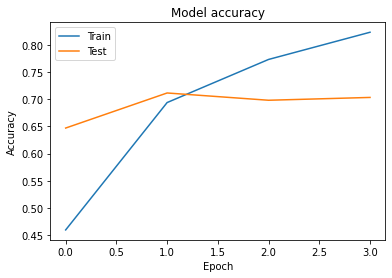

In [ ]:
import matplotlib.pyplot as plt

# 훈련 과정 시각화 (정확도)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

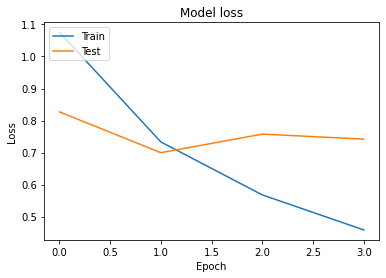

In [ ]:
# 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# results = model.evaluate(X_val, y_val, batch_size=1024)
# print("test loss, test acc: ", results)

# Predict

In [ ]:
pred=model(X_test)

In [ ]:
type(pred)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
#torch.max(pred,1)
re=pred.numpy()
res=re.tolist()

y_prob=[max(x) for x in res]

y_pred=[]
for i,v in enumerate(res):
  y_pred.append(v.index(y_prob[i]))

#res.apply(lambda x:x.index( prob for prob in y_prob ))

#res.apply(lambda x:max(x))
# res=np.array(re.tolist())
# res
#print(type(res))
#indices=np.where(res=res.max())
# print(res[indices])

In [ ]:
len(y_pred)

1666

In [ ]:
y_pred[:5]

[0, 2, 1, 0, 1]

In [ ]:
fin=[ idx_label[i] for i in y_pred]
fin

['contradiction',
 'neutral',
 'entailment',
 'contradiction',
 'entailment',
 'neutral',
 'entailment',
 'entailment',
 'entailment',
 'neutral',
 'contradiction',
 'entailment',
 'neutral',
 'neutral',
 'entailment',
 'entailment',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'contradiction',
 'neutral',
 'neutral',
 'entailment',
 'contradiction',
 'contradiction',
 'contradiction',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'entailment',
 'contradiction',
 'neutral',
 'neutral',
 'contradiction',
 'entailment',
 'contradiction',
 'entailment',
 'neutral',
 'neutral',
 'contradiction',
 'contradiction',
 'neutral',
 'neutral',
 'entailment',
 'neutral',
 'neutral',
 'entailment',
 'neutral',
 'neutral',
 'contradiction',
 'entailment',
 'neutral',
 'neutral',
 'contradiction',
 'contradiction',
 'neutral',
 'contradiction',
 'entailment',
 'entailment',
 'contradiction',
 'neutral',
 'neutral',
 'neutral',
 'contradiction',
 'neutral',
 'neutral',
 'neutral',
 'contradicti

In [ ]:
test_data['label']=fin

In [ ]:
df_sub=pd.read_csv('open/sample_submission.csv')

In [ ]:
df_sub['label']=fin

In [ ]:
df_sub.to_csv('open/kogpt2.csv',index=False)